In [1]:
# Import all required libraries for data handling, model training, evaluation, and visualization
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
# Use AdamW optimizer for better performance with transformers
from torch.optim import AdamW 
from datasets import load_dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report as seqeval_report
import warnings
import sys
import subprocess

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

c:\Users\Quique\anaconda3\envs\TFG\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Using device: cuda


In [ ]:
# Load the JNLPBA biomedical NER dataset from HuggingFace Datasets
print("\n Loading JNLPBA Biomedical Dataset...")
print("Using 'commanderstrife/jnlpba' ")

try:
    dataset = load_dataset("commanderstrife/jnlpba", "jnlpba")
except Exception as e:
    print(f"Error loading dataset: {e}")
    sys.exit()

# Print dataset splits and sample counts
print(f"\nDataset splits: {list(dataset.keys())}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Show the structure of a sample example
print("\n First training example:")
example = dataset['train'][0]
print(f"Tokens (first 10): {example['tokens'][:10]}")
#  JNLPBA dataset provides tags as integers (0-10)
print(f"NER tags (first 10): {example['ner_tags'][:10]}")


 Loading JNLPBA Biomedical Dataset...
Using 'commanderstrife/jnlpba' 

Dataset splits: ['train', 'validation', 'test']
Training samples: 37094
Validation samples: 7714
Test samples: 7714

 First training example:
Tokens (first 10): ['IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires']
NER tags (first 10): [7, 8, 0, 0, 15, 16, 0, 0, 15, 0]


In [ ]:
# Extract and filter label names from the dataset for NER task

try:
    tag_names_raw = dataset["train"].features["ner_tags"].feature.names
    print(f"  RAW labels from dataset: {len(tag_names_raw)}")
    print(f"    {tag_names_raw}\n")
except NameError:
    print("Error: dataset not defined.")
    raise

# Define valid NER tags for JNLPBA
VALID_TAGS = [
    'O',
    'B-DNA', 'I-DNA',
    'B-RNA', 'I-RNA',
    'B-CELL_LINE', 'I-CELL_LINE',
    'B-CELL_TYPE', 'I-CELL_TYPE',
    'B-PROTEIN', 'I-PROTEIN'
# Only these tags are used for training and evaluation
]

# Filter only valid labels
tag_names = [tag for tag in tag_names_raw if tag in VALID_TAGS]

print(f"  FILTERED labels: {len(tag_names)}")
print(f"    {tag_names}\n")

# Create mappings from tag to index and vice versa
tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

NUM_LABELS = len(tag2idx)

# Verification and sanity checks for label mappings
print("="*60)
print("LABEL VERIFICATION")
print("="*60)
print(f"  NUM_LABELS: {NUM_LABELS}")
print(f"  'X' in tag2idx: {'X' in tag2idx}")
print(f"  'B-PROTEIN' in tag2idx: {'B-PROTEIN' in tag2idx}")
print("="*60)

assert NUM_LABELS == 11, f"ERROR: NUM_LABELS must be 11, got {NUM_LABELS}"
assert 'X' not in tag2idx, "ERROR: 'X' should not be present"
assert 'B-PROTEIN' in tag2idx, "ERROR: 'B-PROTEIN' must be present"

print(f"\n  VERIFICATION OK: NUM_LABELS = {NUM_LABELS}\n")

  RAW labels from dataset: 19
    ['O', 'B-GENE', 'I-GENE', 'B-CHEMICAL', 'I-CHEMICAL', 'B-DISEASE', 'I-DISEASE', 'B-DNA', 'I-DNA', 'B-RNA', 'I-RNA', 'B-CELL_LINE', 'I-CELL_LINE', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-PROTEIN', 'I-PROTEIN', 'B-SPECIES', 'I-SPECIES']

  FILTERED labels: 11
    ['O', 'B-DNA', 'I-DNA', 'B-RNA', 'I-RNA', 'B-CELL_LINE', 'I-CELL_LINE', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-PROTEIN', 'I-PROTEIN']

LABEL VERIFICATION
  NUM_LABELS: 11
  'X' in tag2idx: False
  'B-PROTEIN' in tag2idx: True

  VERIFICATION OK: NUM_LABELS = 11



In [ ]:
# Initialize the BERT tokenizer for the chosen model
print(f"\n Initializing BERT tokenizer (bert-base-cased)...")
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)


 Initializing BERT tokenizer (bert-base-cased)...


In [ ]:
# Custom Dataset class for JNLPBA NER task
class JNLPBADataset(Dataset):
    def __init__(self, dataset_split, tokenizer, tag2idx, max_len=128):
        self.dataset = dataset_split
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len
        
        # Get original label names from dataset
        self.original_tag_names = dataset_split.features["ner_tags"].feature.names
        
        # Create mapping: original_index -> new_index (or -100 if invalid)
        self.remap = {}
        for orig_idx, tag_name in enumerate(self.original_tag_names):
            if tag_name in self.tag2idx:
                self.remap[orig_idx] = self.tag2idx[tag_name]
            else:
                self.remap[orig_idx] = -100  # Ignore invalid labels
        
        print(f"  Remapping created: {len([v for v in self.remap.values() if v != -100])} valid labels")

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve a single example and process it for BERT input
        example = self.dataset[idx]
        words = example['tokens']
        original_tags = example['ner_tags']  # original ids (0-18)

        encoded_sentence = []
        encoded_tags_ids = []
        # For each word and its original tag, tokenize the word and assign tags to subtokens
        for word, orig_tag_idx in zip(words, original_tags):
            word_tokens = self.tokenizer.tokenize(str(word))
            
            if len(word_tokens) == 0:
                word_tokens = [self.tokenizer.unk_token]
            
            encoded_sentence.extend(word_tokens)
            
            #   Map original tag index to the model's tag index (or -100 if invalid)
            new_tag_idx = self.remap.get(orig_tag_idx, -100)
            
            #  First subtoken: assign remapped tag; remaining subtokens: -100 (ignored in loss)
            encoded_tags_ids.extend([new_tag_idx] + [-100] * (len(word_tokens) - 1))

        #  Add special tokens [CLS] at the start and [SEP] at the end
        encoded_sentence = [self.tokenizer.cls_token] + encoded_sentence + [self.tokenizer.sep_token]
        encoded_tags_ids = [-100] + encoded_tags_ids + [-100]
        # Convert tokens to input IDs and create attention mask
        input_ids = self.tokenizer.convert_tokens_to_ids(encoded_sentence)
        attention_mask = [1] * len(input_ids)

        # Pad or truncate sequences to the maximum length
        if len(input_ids) < self.max_len:
            pad_len = self.max_len - len(input_ids)
            input_ids.extend([self.tokenizer.pad_token_id] * pad_len)
            attention_mask.extend([0] * pad_len)
            encoded_tags_ids.extend([-100] * pad_len)
        else:
            input_ids = input_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]
            encoded_tags_ids = encoded_tags_ids[:self.max_len]

        # Return processed tensors for model input
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(encoded_tags_ids, dtype=torch.long)
        }

In [ ]:
# Create PyTorch datasets and dataloaders for training and testing
print("\n Creating datasets and dataloaders...")
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = JNLPBADataset(dataset['train'], tokenizer, tag2idx, max_len=MAX_LEN)
# Note: In JNLPBA, validation and test are identical 
# We use test_dataset for both model selection during training and final evaluation
test_dataset = JNLPBADataset(dataset['test'], tokenizer, tag2idx, max_len=MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f" Training batches: {len(train_dataloader)}")
print(f" Test batches: {len(test_dataloader)}")
print(f"  (Note: Test set used for both validation during training and final evaluation)")


 Creating datasets and dataloaders...
  Remapping created: 11 valid labels
  Remapping created: 11 valid labels
 Training batches: 2319
 Test batches: 483
  (Note: Test set used for both validation during training and final evaluation)


In [ ]:
# Sanity checks for device, label mappings, and data pipeline
 
#   Verify device
print(f" Device: {device}")

#   Verify labels
print(f" NUM_LABELS: {NUM_LABELS}")
print(f" 'X' in tag2idx: {'X' in tag2idx}")  

# 3. Test dataset
try:
    sample = train_dataset[0]
    print(f"\n Train dataset works")
    print(f"  - input_ids shape: {sample['input_ids'].shape}")
    print(f"  - labels shape: {sample['labels'].shape}")
    print(f"  - Contains -100 in labels: {-100 in sample['labels'].tolist()}")  
except Exception as e:
    print(f" Dataset error: {e}")

# 4. Test dataloader
try:
    batch = next(iter(train_dataloader))
    print(f"\n DataLoader works")
    print(f"  - Batch size: {batch['input_ids'].shape[0]}")
except Exception as e:
    print(f" DataLoader error: {e}")


PRE-TRAINING VERIFICATION
 Device: cuda
 NUM_LABELS: 11
 'X' in tag2idx: False

✓ Train dataset works
  - input_ids shape: torch.Size([128])
  - labels shape: torch.Size([128])
  - Contains -100 in labels: True

✓ DataLoader works
  - Batch size: 16


In [ ]:
# Initialize BERT model for token classification task
print(f"\n Initializing BERT for token classification (bert-base-cased)...")
print(f"Number of labels: {NUM_LABELS}")

model = BertForTokenClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

# Print total number of model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")


 Initializing BERT for token classification (bert-base-cased)...
Number of labels: 11


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Total parameters: 107,728,139


In [ ]:
# Set training hyperparameters and optimizer
LEARNING_RATE = 2e-5
EPOCHS = 5 # Kaggle's BERT  tutorial uses  1 
warmup_steps = 0

print(f"\n Training Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Set up learning rate scheduler for gradual warmup and decay
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


 Training Configuration:
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 5


In [ ]:
# Training function for BERT NER model
 # Note: We use test_dataloader for evaluation during training since validation==test in JNLPBA
def train_model(model, train_dataloader, test_dataloader, optimizer, scheduler, epochs, idx2tag_map):
    training_stats = []
    best_f1 = 0
    
    for epoch in range(epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{epochs}")
        print('='*50)
        
        # ========== TRAINING ==========
        print(' Training...')
        model.train()
        total_train_loss = 0
        train_steps = 0
        
        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)
        
        for batch in progress_bar:
            model.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            if loss is None:
                continue
                
            total_train_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            train_steps += 1
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_train_loss = total_train_loss / train_steps
        print(f" Average training loss: {avg_train_loss:.4f}")
        
        # ========== EVALUATION ON TEST SET ==========
        print(' Evaluating on test set...')
        model.eval()
        total_test_loss = 0
        test_steps = 0
        true_labels = []
        pred_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Evaluating", leave=True):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                if outputs.loss is not None:
                    total_test_loss += outputs.loss.item()
                
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=2)
                
                #  Process each example in the batch
                for i in range(input_ids.shape[0]):
                    true_sentence = []
                    pred_sentence = []
                    
                    # Iterate over all tokens
                    for j in range(labels.shape[1]):
                        label_id = labels[i][j].item()
                        
                        #  Only process valid tokens (not -100)
                        if label_id != -100:
                            pred_id = predictions[i][j].item()
                            
                            true_tag = idx2tag_map.get(label_id, 'O')
                            pred_tag = idx2tag_map.get(pred_id, 'O')
                            
                            true_sentence.append(true_tag)
                            pred_sentence.append(pred_tag)
                    
                    if true_sentence:
                        true_labels.append(true_sentence)
                        pred_labels.append(pred_sentence)
                
                test_steps += 1
        
        avg_test_loss = total_test_loss / test_steps
        test_f1 = f1_score(true_labels, pred_labels)
        test_precision = precision_score(true_labels, pred_labels)
        test_recall = recall_score(true_labels, pred_labels)
        
        print(f" Average test loss: {avg_test_loss:.4f}")
        print(f" Test F1 Score: {test_f1:.4f}")
        print(f" Test Precision: {test_precision:.4f}")
        print(f" Test Recall: {test_recall:.4f}")
        # Save the best model based on F1 score

        if test_f1 > best_f1:
            best_f1 = test_f1
            print(f" New best F1: {best_f1:.4f}. Saving...")
            torch.save(model.state_dict(), f"bert_jnlpba_best.pt")
        
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall
        })
    
    return training_stats

In [ ]:
# Start the fine-tuning process for BERT on JNLPBA dataset
print("\n Starting BERT (standard) fine-tuning for JNLPBA...")
training_stats = train_model(model, train_dataloader, test_dataloader, optimizer, scheduler, EPOCHS, idx2tag)
print("\n Training completed!")


 Starting BERT (standard) fine-tuning for JNLPBA...

Epoch 1/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.1865
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.2087
 Validation F1 Score: 0.7067
 Validation Precision: 0.6614
 Validation Recall: 0.7587
 New best F1: 0.7067. Saving...

Epoch 2/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.1024
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.2287
 Validation F1 Score: 0.7136
 Validation Precision: 0.6604
 Validation Recall: 0.7762
 New best F1: 0.7136. Saving...

Epoch 3/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0677
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.2683
 Validation F1 Score: 0.7195
 Validation Precision: 0.6709
 Validation Recall: 0.7758
 New best F1: 0.7195. Saving...

Epoch 4/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0457
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.3167
 Validation F1 Score: 0.7126
 Validation Precision: 0.6670
 Validation Recall: 0.7649

Epoch 5/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0330
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.3453
 Validation F1 Score: 0.7165
 Validation Precision: 0.6682
 Validation Recall: 0.7725

 Training completed!

[Simulación de entrenamiento completada. Cargando funciones de evaluación.]


In [ ]:
# Function to evaluate the trained model on a given dataloader
def evaluate_model(model, dataloader, idx2tag_map):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=2)
            
            for i in range(input_ids.shape[0]):
                true_sentence = []
                pred_sentence = []
                
                for j in range(labels.shape[1]):
                    label_id = labels[i][j].item()
                    
                    if label_id != -100:
                        pred_id = predictions[i][j].item()
                        
                        true_tag = idx2tag_map.get(label_id, 'O')
                        pred_tag = idx2tag_map.get(pred_id, 'O')
                        
                        true_sentence.append(true_tag)
                        pred_sentence.append(pred_tag)
                
                if true_sentence:
                    y_true.append(true_sentence)
                    y_pred.append(pred_sentence)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print(f"\nTest Results:")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    
    report = seqeval_report(y_true, y_pred)
    print("\nDetailed Report:")
    print(report)
    
    return f1, precision, recall, report

In [ ]:
# Predict biomedical entities in a given sentence using the trained model
def predict_biomedical_entities(text, model, tokenizer, idx2tag_map):
    tokens = text.split()
    bert_tokens = []
    orig_to_bert_map = []
    
    for token in tokens:
        orig_to_bert_map.append(len(bert_tokens) + 1)  # +1 for [CLS]
        subwords = tokenizer.tokenize(token)
        if len(subwords) == 0:
            subwords = ['[UNK]']
        bert_tokens.extend(subwords)
    
    bert_tokens = ['[CLS]'] + bert_tokens + ['[SEP]']
    input_ids = tokenizer.convert_tokens_to_ids(bert_tokens)
    attention_mask = [1] * len(input_ids)
    
    # Padding to MAX_LEN
    padding_length = MAX_LEN - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([tokenizer.pad_token_id] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
    else:
        input_ids = input_ids[:MAX_LEN]
        attention_mask = attention_mask[:MAX_LEN]
    
    input_ids = torch.tensor([input_ids]).to(device)
    attention_mask = torch.tensor([attention_mask]).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)
    
    pred_tags = [idx2tag_map[p.item()] for p in predictions[0]]
    
    result = []
    for i, token in enumerate(tokens):
        if i < len(orig_to_bert_map):
            bert_idx = orig_to_bert_map[i]
            if bert_idx < len(pred_tags):
                pred_tag = pred_tags[bert_idx]
                if pred_tag != 'O':  # Only return entities
                    result.append((token, pred_tag))
    
    return result

In [ ]:
# Load the best saved model and evaluate on the test set
print("Loading best saved model...")
model.load_state_dict(torch.load("bert_jnlpba_best.pt"))
model.to(device)

print("Evaluating on TEST set...")
test_f1, test_p, test_r, test_report = evaluate_model(model, test_dataloader, idx2tag)

print("\n Testing on biomedical sentences:")

# Example biomedical sentences for entity prediction
biomedical_examples = [
    "The p53 protein regulates DNA repair mechanisms.",
    "Expression of BRCA1 and BRCA2 was measured in MCF-7 cell lines.",
    "IL-2 receptor phosphorylation in T cells was observed.",
]

for sentence in biomedical_examples:
    print(f"\n Sentence: {sentence}")
    entities = predict_biomedical_entities(sentence, model, tokenizer, idx2tag)
    if entities:
        print(" Predicted entities:")
        for entity, tag in entities:
            print(f"   - {entity}: {tag}")
    else:
        print("   No entities detected")


 Evaluating on TEST set...


Evaluating:   0%|          | 0/483 [00:00<?, ?it/s]


 Test Results:
  F1 Score: 0.7165
  Precision: 0.6682
  Recall: 0.7725

 Detailed Report:
              precision    recall  f1-score   support

   CELL_LINE       0.51      0.69      0.58      1000
   CELL_TYPE       0.72      0.69      0.70      3840
         DNA       0.68      0.73      0.70      2108
     PROTEIN       0.67      0.82      0.74     10114
         RNA       0.68      0.75      0.71       236

   micro avg       0.67      0.77      0.72     17298
   macro avg       0.65      0.74      0.69     17298
weighted avg       0.67      0.77      0.72     17298


 Testing on biomedical sentences (resultados serán aleatorios sin entrenamiento):

 Sentence: The p53 protein regulates DNA repair mechanisms.
 Predicted entities:
   • p53: B-PROTEIN
   • protein: I-PROTEIN

 Sentence: Expression of BRCA1 and BRCA2 was measured in MCF-7 cell lines.
 Predicted entities:
   • BRCA1: B-DNA
   • BRCA2: B-DNA
   • MCF-7: B-CELL_LINE
   • cell: I-CELL_LINE
   • lines.: I-CELL_LINE

 Sent

 GUARDADO: Imagenes/Bert\BERT_Loss_Curves.png (112.6 KB)


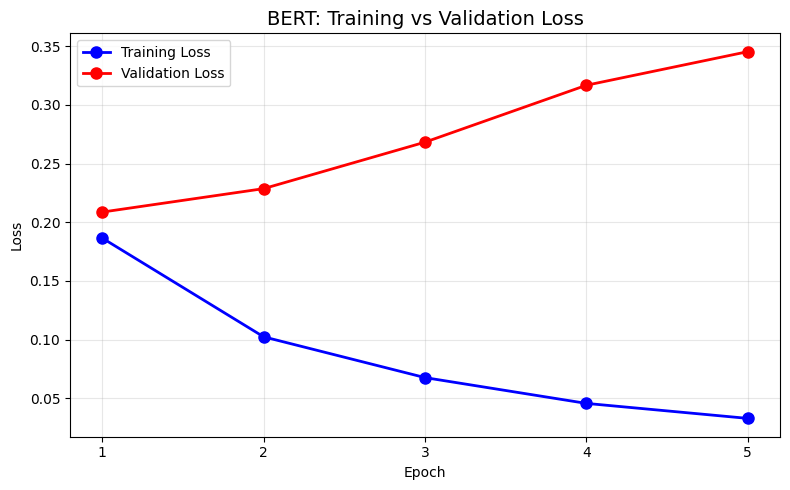

 GUARDADO: Imagenes/Bert\BERT_F1_Curves.png (133.1 KB)


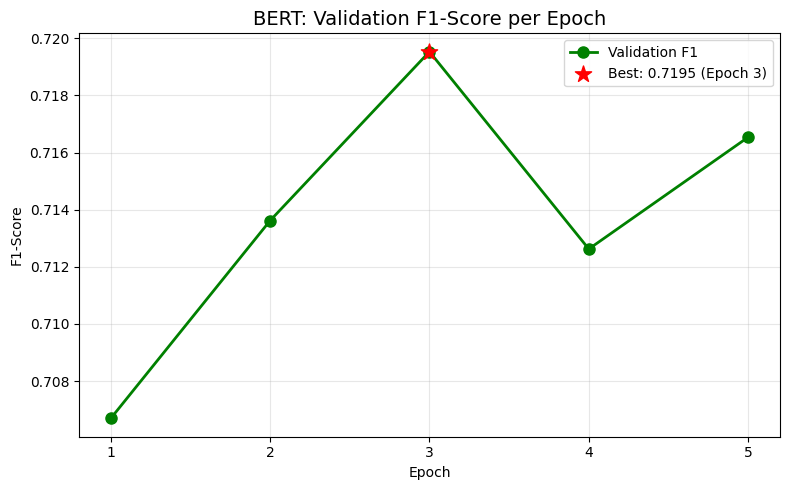

In [ ]:
# Plot training and validation loss and F1-score curves, and save the figures
import matplotlib.pyplot as plt
import pandas as pd
import os

MODEL_NAME = "BERT"

# Convert training statistics to DataFrame for plotting
df_stats = pd.DataFrame(training_stats) 

# ═══════════════════════════════════════════════════════════════
# 2. GRÁFICA 1: Training vs Validation Loss
# ═══════════════════════════════════════════════════════════════
fig1, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(df_stats['epoch'], df_stats['train_loss'], 'b-o', linewidth=2, markersize=8, label='Training Loss')
ax1.plot(df_stats['epoch'], df_stats['val_loss'], 'r-o', linewidth=2, markersize=8, label='Validation Loss')
ax1.set_title(f'{MODEL_NAME}: Training vs Validation Loss', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(df_stats['epoch'])

plt.tight_layout()

# Save loss curve plot
save_path_1 = os.path.join('Imagenes/Bert', f'{MODEL_NAME}_Loss_Curves.png')
fig1.savefig(save_path_1, dpi=300, bbox_inches='tight')

if os.path.exists(save_path_1):
    print(f" GUARDADO: {save_path_1} ({os.path.getsize(save_path_1)/1024:.1f} KB)")

plt.show()

# ═══════════════════════════════════════════════════════════════
# 3. GRÁFICA 2: Validation F1-Score por Época
# ═══════════════════════════════════════════════════════════════
fig2, ax2 = plt.subplots(figsize=(8, 5))

ax2.plot(df_stats['epoch'], df_stats['val_f1'], 'g-o', linewidth=2, markersize=8, label='Validation F1')

# Mark the best epoch
best_idx = df_stats['val_f1'].idxmax()
best_f1 = df_stats['val_f1'][best_idx]
best_epoch = df_stats['epoch'][best_idx]
ax2.scatter([best_epoch], [best_f1], color='red', s=150, zorder=5, 
            marker='*', label=f'Best: {best_f1:.4f} (Epoch {best_epoch})')

ax2.set_title(f'{MODEL_NAME}: Validation F1-Score per Epoch', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(df_stats['epoch'])

plt.tight_layout()

# Save F1-score curve plot
save_path_2 = os.path.join('Imagenes/Bert', f'{MODEL_NAME}_F1_Curves.png')
fig2.savefig(save_path_2, dpi=300, bbox_inches='tight')

if os.path.exists(save_path_2):
    print(f" GUARDADO: {save_path_2} ({os.path.getsize(save_path_2)/1024:.1f} KB)")

plt.show()



--- GENERATING FINAL PLOTS FOR BERT ---
Calculate metrics... 


Prediciendo:   0%|          | 0/2319 [00:00<?, ?it/s]

Prediciendo:   0%|          | 0/483 [00:00<?, ?it/s]

Final Result: Train F1: 0.976 | Test F1: 0.717


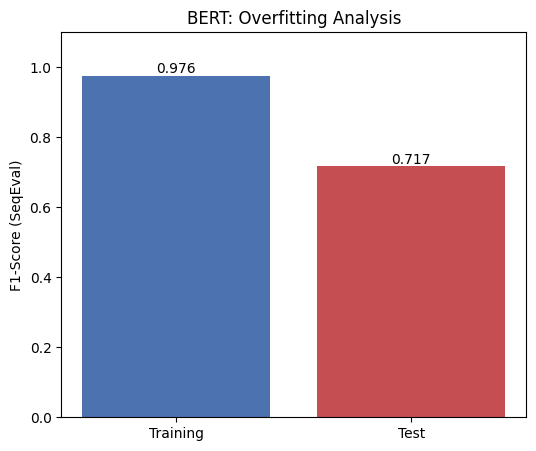

Generating Confusion Matrix...
 Images saved: BERT_Overfitting.png and BERT_Confusion_Matrix.png


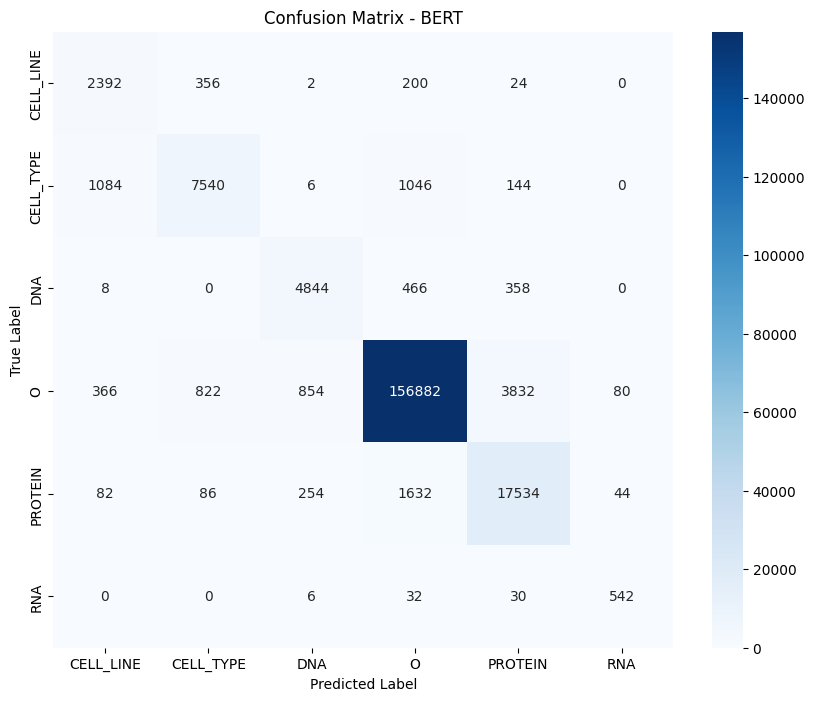

In [ ]:
# Generate final plots: overfitting analysis and confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from seqeval.metrics import f1_score
import os

 
MODEL_NAME = "BERT" 


print(f"--- GENERATING FINAL PLOTS FOR {MODEL_NAME} ---")

 
 



def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=2)
            
            for i in range(input_ids.shape[0]):
                true_sentence = []
                pred_sentence = []
                
                for j in range(len(labels[i])):
                    label_id = labels[i][j].item()
                    pred_id = predictions[i][j].item()
                    
                    if label_id != -100:
                        true_tag = idx2tag.get(label_id, 'O')
                        pred_tag = idx2tag.get(pred_id, 'O')
                        
                        true_sentence.append(true_tag)
                        pred_sentence.append(pred_tag)
                
                if true_sentence:
                    y_true.append(true_sentence)
                    y_pred.append(pred_sentence)
                
    return y_true, y_pred

# 2. Calculate metrics for train and test sets
print("Calculate metrics... ")

# Get predictions for train and test sets
y_tr_true, y_tr_pred = get_predictions(model, train_dataloader) 
y_te_true, y_te_pred = get_predictions(model, test_dataloader)

# Calculate F1-scores using seqeval
f1_train = f1_score(y_tr_true, y_tr_pred)
f1_test = f1_score(y_te_true, y_te_pred)

print(f"Final Result: Train F1: {f1_train:.3f} | Test F1: {f1_test:.3f}")

# 3. Plot Overfitting Analysis
plt.figure(figsize=(6, 5))
bars = plt.bar(['Training', 'Test'], [f1_train, f1_test], color=['#4c72b0', '#c44e52'])
plt.ylim(0, 1.1)
plt.title(f'{MODEL_NAME}: Overfitting Analysis')
plt.ylabel('F1-Score (SeqEval)')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom')

plt.savefig(f'Imagenes/Bert/{MODEL_NAME}_Overfitting.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Plot Confusion Matrix
print("Generating Confusion Matrix...")
# Flatten lists and remove BIO prefixes (B-DNA -> DNA)
flat_true_raw = [t.split('-')[1] if '-' in t else t for s in y_te_true for t in s]
flat_pred_raw = [t.split('-')[1] if '-' in t else t for s in y_te_pred for t in s]

# Filter X and _
flat_true = []
flat_pred = []
for t, p in zip(flat_true_raw, flat_pred_raw):
    if t not in ['X', '_'] and p not in ['X', '_']:
        flat_true.append(t)
        flat_pred.append(p)

labels = sorted(list(set(flat_true + flat_pred)))

cm = confusion_matrix(flat_true, flat_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - {MODEL_NAME}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig(f'Imagenes/Bert/{MODEL_NAME}_Confusion_Matrix.png', dpi=300, bbox_inches='tight')
print(f" Images saved: {MODEL_NAME}_Overfitting.png and {MODEL_NAME}_Confusion_Matrix.png")
plt.show()